### Submission 1: Price a European Up-and-out Call Option

In [39]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
### Initialize problem parameters
# option maturity
T = 1
# up-and-out barrier
L = 150
# current share price
S0 = 100
# strike price, at-the-money
K = 100
# risk-free rate
r = .08
# volatility
sigma = .3

# counterparty firm current value
v_0 = 200 # Our assumption 
# volatility for the counterparty's firm
sigma_firm = .25
# counterparty's debt, due in one year 
debt = 175
# correlation
corr = .2
# recovery rate
delta = 0.25

########

sample_sizes = range(1000, 50001, 1000)

In [ ]:
#### 1. Simulate paths for the underlying share and for the counterparty’s firm value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option.

In [213]:
def share_price(S, r, sigma, t_delta, Z):
    return S * np.exp((r - sigma**2/2)*t_delta + sigma*np.sqrt(t_delta)*Z) # dot product


def generate_share_price(S0, r, sigma, T, sample_size = 1000, timesteps = 12):
    price = [np.array([S0]*sample_size)]
    St = S0
    t, dt = np.linspace(0, T, timesteps+1, retstep=True)
    for _ in t[:-1]: # exclude the last time point as that is the maturity
        Z = stats.norm.rvs(size=sample_size)
        St = share_price(St, r, sigma, dt, Z)
        price.append(St)
    price = np.array(price)
    return pd.DataFrame(price, index=range(timesteps+1))

def generate_share_and_firm_price(S0, v_0, r, sigma, sigma_firm, corr, T, sample_size = 1000, timesteps = 12):

    for i in range(sample_size):
        corr_matrix = np.array([[1, corr], [corr, 1]])
        norm_matrix = norm.rvs(size = np.array([2, timesteps]))
        corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
        share_price_path = pd.DataFrame(share_price(S0, r, sigma, t_delta=1/timesteps, Z=corr_norm_matrix[0,]))
        share_price_path = share_price_path.rename(columns={0: i})
        firm_price_path = pd.DataFrame(share_price(V0, r, sigma_firm, t_delta=1/timesteps, Z=corr_norm_matrix[1,]))
        firm_price_path = firm_price_path.rename(columns={0: i})
        
        if i == 0:
            share_price_df = share_price_path
            firm_price_df = firm_price_path
            
        else:
            share_price_df=share_price_df.merge(share_price_path, left_index=True, right_index=True)
            firm_price_df=firm_price_df.merge(firm_price_path, left_index=True, right_index=True
            
    return [share_price_df,firm_price_df]  


In [220]:
#Testing share and firm price correlation
sample_size = 20
test = generate_share_and_firm_price(S0, v_0, r, sigma, sigma_firm, corr, T, sample_size, timesteps = 20000)

for i in range(sample_size):
    print(pearsonr(test[0][i], test[1][i]))

(0.18772181482795539, 4.8769126604026575e-158)
(0.19711383983270153, 2.3314936361204523e-174)
(0.1976988525997347, 2.1022673808929003e-175)
(0.1961985222732172, 9.905383106086456e-173)
(0.20133014083699063, 5.7766354857815335e-182)
(0.1760116175963244, 7.012885317301764e-139)
(0.20076862546402713, 6.09057272325776e-181)
(0.19207509530928324, 1.6976021087009934e-165)
(0.1961987774038959, 9.895063125565571e-173)
(0.19307856627591677, 3.0521052930136868e-167)
(0.18961457420066666, 2.9367882505247808e-161)
(0.19318264827307163, 2.009188840802396e-167)
(0.1955110043816657, 1.634974736743746e-171)
(0.21049324946425915, 4.262001830138127e-199)
(0.1936999882187431, 2.5056585136597893e-168)
(0.20469135474840616, 3.744607609806022e-188)
(0.20021511063808003, 6.166541987281294e-180)
(0.21574845143269133, 2.6844210936843856e-209)
(0.19900195621384711, 9.61786595237011e-178)
(0.19577741682686983, 5.523613995989007e-172)


Let's try to simulate the share price with a small number of sample paths and visualize them over the course of 12 months

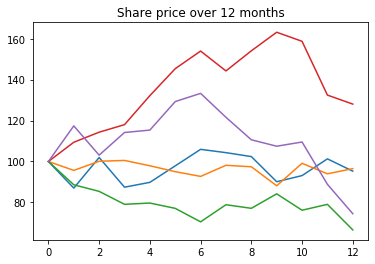

In [72]:
share_price_12_months = generate_share_price(S0, r, sigma, T, sample_size=5)
share_price_12_months.plot(title='Share price over 12 months', legend=False)

We can do the same thing to simulate counterparty firm's value

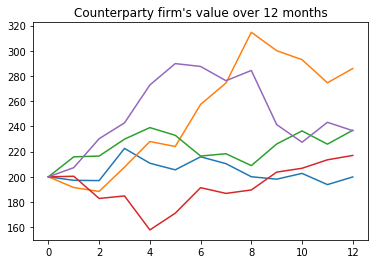

In [15]:
firm_value_12_months = generate_share_price(v_0, r, sigma_firm, T, sample_size=5)
firm_value_12_months.plot(title="Counterparty firm's value over 12 months", legend=False)

In fact, we can also simulate the dynamic with finer resolution.

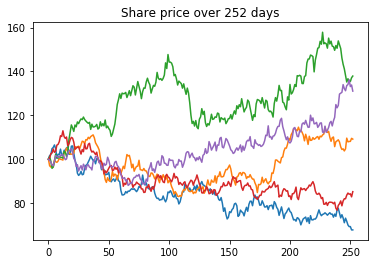

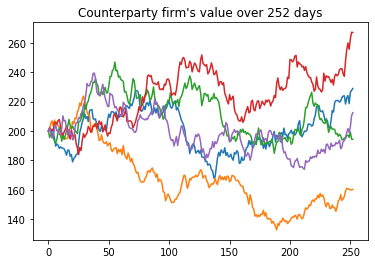

In [16]:
share_price_252_days = generate_share_price(S0, r, sigma, T, sample_size=5, timesteps=252)
share_price_252_days.plot(title='Share price over 252 days', legend=False)
firm_value_252_days = generate_share_price(v_0, r, sigma_firm, T, sample_size=5, timesteps=252)
firm_value_252_days.plot(title="Counterparty firm's value over 252 days", legend=False)

Let's visualize when the stopped process is appied

In [17]:
def stop(s, cond):
    ret = s.copy()
    r = ret[cond]
    if len(r) > 0:
        print(r)
        ret[r.idxmin():] = 0
    return ret

11    157.698379
12    170.253244
Name: 0, dtype: float64
11    157.698379
12    170.253244
Name: 0, dtype: float64


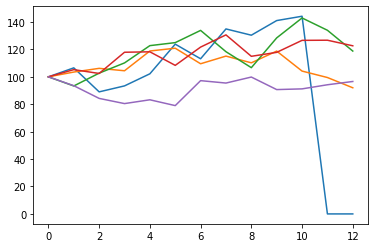

In [18]:
share_price_12_months.apply(lambda s: stop(s, s>L), axis=0).plot(legend=False)

In [19]:
# define payoff for up-and-out call option
def payoff(S_t, K, L):
    stopped_S = S_t.iloc[-1].where((S_t < L).all(), 0)
    return np.maximum(stopped_S - K, 0).to_numpy()

payoff(share_price_12_months, K, L)

array([ 0.        ,  0.        , 18.79897564, 22.63577867,  0.        ])

Now let's increase the sample size to be able to estimate the mean price more accurately

In [ ]:
share_price_paths = {}
firm_val_paths = {}

for sample_size in sample_sizes:
    share_val, firm_val = generate_share_and_firm_price(S0, v_0, r, sigma, sigma_firm, corr, T, sample_size = sample_size, timesteps = 12)
     
    share_price_paths[sample_size] = share_val
    firm_val_paths[sample_size] = firm_val

In [21]:
%%capture
option_paths = share_price_paths[1000].apply(lambda s: stop(s, s>L), axis=0)

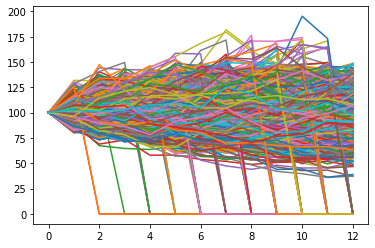

In [22]:
# plot monthly simulations for the lifetime of the option
option_paths.plot(legend=False)

#### 2. Determine the Monte Carlo estimates of the both the default-free value of the option and the Credit Valuation Adjustment

In [23]:
# Estimate the default-free value of the option:
option_estimate = [None] * 50
option_std = [None] * 50

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    option_price = np.exp(-r*T)*payoffs
    option_estimate.append(option_price.mean())
    option_std.append(option_price.std()/np.sqrt(sample_size))


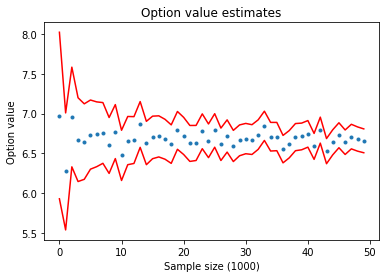

In [24]:
plt.plot(option_estimate, '.')
plt.plot(option_estimate + 3 * np.array(option_std), 'r')
plt.plot(option_estimate - 3 * np.array(option_std), 'r')
plt.title("Option value estimates")
plt.xlabel("Sample size (1000)")
plt.ylabel("Option value")
plt.show()

CVA calculation

In [26]:
cva_estimates = [None] * 50



for sample_size, paths in share_price_paths.items(): 

50

In [32]:
share_price_paths[2000]

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,91.213403,93.663663,98.031137,90.781474,109.238696,100.439036,80.952783,91.521866,102.645292,105.431119,...,80.238898,95.865291,105.820276,91.087712,97.909446,100.268195,105.586304,90.987113,92.138808,101.228966
2,91.814606,100.234802,98.624068,87.290444,111.666973,100.198017,83.322046,86.592558,92.596879,115.294740,...,71.144069,88.314694,91.384742,83.215558,94.892405,101.764134,100.247256,86.684237,94.784815,110.021049
3,88.362496,93.106597,98.647882,104.348941,120.917186,95.071415,83.017639,92.413817,87.206567,98.006016,...,76.648344,87.154822,83.514028,78.328348,106.278102,114.215825,104.938070,81.731235,96.000104,111.221220
4,91.500817,92.970147,112.800863,112.851427,115.357013,91.515955,106.595145,88.761402,87.028911,94.522683,...,85.004198,83.588671,85.822720,65.626032,108.701996,107.472053,125.256184,89.423991,77.863007,104.551645
5,92.346881,93.589128,126.125811,99.470972,110.710074,84.080083,95.390275,91.125822,74.833623,92.620575,...,73.833534,93.046209,100.055496,70.383096,127.337938,111.967728,133.260954,85.857944,82.478731,108.724172
6,94.717723,100.986646,127.904331,97.906294,109.884426,84.326709,84.954732,94.188447,72.177716,94.983161,...,64.618364,96.688930,100.749317,76.176337,141.885140,120.078105,120.930072,87.489898,82.117997,117.177025
7,100.415889,103.028035,142.804340,91.919692,105.114109,76.240770,77.029728,87.655616,67.449880,108.332063,...,65.982671,101.188891,96.685119,65.326607,166.097929,108.196236,104.159029,90.513258,77.292454,117.127494
8,93.254003,100.928654,164.799108,86.645636,115.714008,66.690031,81.596734,98.353206,67.414965,100.354042,...,70.496606,110.244767,100.893215,60.338349,144.140994,123.698796,113.463801,91.997212,89.291180,125.268429
9,78.280400,116.316079,160.394930,73.095247,117.147551,70.629604,79.203086,97.648835,66.775781,102.104918,...,82.557020,114.063592,113.452432,54.886139,159.604919,123.242665,115.616938,100.037379,92.917894,122.204343
